In [1]:
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , Input
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn import metrics
from keras import regularizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
data = np.load('../input/cnn-data-new/Train_RAW_v2.npz')

In [3]:
test_data = np.load('../input/cnn-data-new/Test_RAW_v2.npz')

In [4]:
X_test = test_data['features']
Y_test = test_data['labels']

In [5]:
data.files

['features', 'labels']

In [6]:
features = data['features']
labels = data['labels']

In [7]:
img = np.reshape(features[9],(150,150,3))

(-0.5, 149.5, 149.5, -0.5)

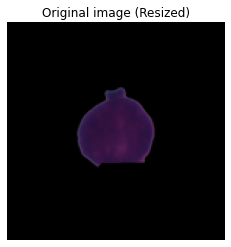

In [8]:
plt.imshow(img)
plt.title('Original image (Resized)')
plt.axis('off')

In [9]:
#X_train, X_val, Y_train, Y_val = train_test_split(features, labels, test_size=0.20, random_state=42)

In [10]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)

print(class_weights)

[1.03639344 0.96607579]


In [11]:
def build_cnn():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150,150,3) , activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256 ,  activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    model.add(Dense(2 , activation ='softmax'))

    return model

In [12]:
model = build_cnn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)      

In [14]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=7, random_state=None)

cvscores = []
acc = []
vacc = []
loss = []
vloss = []
i = 0
for train_index, val_index in skf.split(features,labels):
    i = i + 1
    X_train, X_val = features[train_index], features[val_index]
    Y_train, Y_val = labels[train_index], labels[val_index]
    name = 'model_RAW_v' + str(i) + '.hdf5'
    mcp = ModelCheckpoint(filepath=name, monitor="val_accuracy", save_best_only=True, save_weights_only=False)
    
    print('\n')
    print('Start Training Fold_' + str(i)+'--------------------------------------')
    #print('\n')
    hist = model.fit(X_train,Y_train, validation_data = (X_val,Y_val) , 
                         epochs = 20,verbose=1,class_weight = class_weights,callbacks=[mcp])
    print('\n')
    scores = model.evaluate(X_val,Y_val, verbose=1)
    print('\n-------------Model Evaluation Results '+ 'Fold_' + str(i) + '-----------')
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print('\n------------------------------------------------------------------------------------------------------------')
    cvscores.append(scores[1] * 100)
    acc.append(hist.history['accuracy'])
    vacc.append(hist.history['val_accuracy'])
    loss.append(hist.history['loss'])
    vloss.append(hist.history['val_loss'])

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Start Training Fold_1--------------------------------------
Train on 10837 samples, validate on 1807 samples
Epoch 1/20
10837/10837 [==============================] - 19s 2ms/step - loss: 0.5500 - accuracy: 0.7593 - val_loss: 0.4638 - val_accuracy: 0.8046
Epoch 2/20
10837/10837 [==============================] - 12s 1ms/step - loss: 0.4330 - accuracy: 0.8109 - val_loss: 2.1358 - val_accuracy: 0.6220
Epoch 3/20
10837/10837 [==============================] - 12s 1ms/step - loss: 0.3981 - accuracy: 0.8262 - val_loss: 1.2573 - val_accuracy: 0.6884
Epoch 4/20
10837/10837 [==============================] - 12s 1ms/step - loss: 0.3842 - accuracy: 0.8321 - val_loss: 2.0506 - val_accuracy: 0.6835
Epoch 5/20
10837/10837 [==============================] - 12s 1ms/step - loss: 0.3727 - accuracy: 0.8361 - val_loss: 1.3579 - val_accuracy: 0.7421
Epoch 6/20
10837/10837 [==============================] - 12s 1ms/step - loss: 0.3539 - accuracy: 0.8469 - val_loss: 0.4984 - val_accuracy: 0.8019
Epoch 7

Epoch 11/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0785 - accuracy: 0.9700 - val_loss: 0.0915 - val_accuracy: 0.9635
Epoch 12/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0735 - accuracy: 0.9729 - val_loss: 0.1551 - val_accuracy: 0.9424
Epoch 13/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0739 - accuracy: 0.9728 - val_loss: 0.2025 - val_accuracy: 0.9291
Epoch 14/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0692 - accuracy: 0.9736 - val_loss: 0.1361 - val_accuracy: 0.9496
Epoch 15/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0654 - accuracy: 0.9758 - val_loss: 0.1742 - val_accuracy: 0.9319
Epoch 16/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0700 - accuracy: 0.9743 - val_loss: 0.2085 - val_accuracy: 0.9264
Epoch 17/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0644 - accuracy: 0.9767 - val_



Start Training Fold_6--------------------------------------
Train on 10838 samples, validate on 1806 samples
Epoch 1/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0454 - accuracy: 0.9847 - val_loss: 0.3270 - val_accuracy: 0.8810
Epoch 2/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0365 - accuracy: 0.9872 - val_loss: 0.0848 - val_accuracy: 0.9662
Epoch 3/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.0139 - val_accuracy: 0.9972
Epoch 4/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0408 - accuracy: 0.9840 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 5/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0408 - accuracy: 0.9861 - val_loss: 0.0158 - val_accuracy: 0.9945
Epoch 6/20
10838/10838 [==============================] - 12s 1ms/step - loss: 0.0399 - accuracy: 0.9872 - val_loss: 0.0051 - val_accuracy: 0.9994
Epoch 7

# Predictions on Test Data

In [15]:
X_test.shape

(1406, 150, 150, 3)

In [16]:
# Cross-Validation Predictions
test_results = model.evaluate(X_test,Y_test)
y_test_pred = model.predict_classes(X_test)

print('\nCV_Results_Overall Model Performance')
print(test_results)

1406/1406 [==============================] - 1s 430us/step

CV_Results_Overall Model Performance
[0.302349559824972, 0.9096728563308716]


## Evaluation of each fold

In [18]:
fold_results = []

In [19]:
model.load_weights('../input/weights/model_RAW_v1.hdf5')
fold1_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_1---')
print(fold1_results)
fold_results.append(fold1_results)

1406/1406 [==============================] - 1s 401us/step

---CV_Results_Fold_1---
[0.27239188204279663, 0.8918918967247009]


In [20]:
model.load_weights('../input/weights/model_RAW_v2.hdf5')
fold2_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_2---')
print(fold2_results)
fold_results.append(fold2_results)

1406/1406 [==============================] - 1s 391us/step

---CV_Results_Fold_2---
[0.2260591287277162, 0.9189189076423645]


In [21]:
model.load_weights('../input/weights/model_RAW_v3.hdf5')
fold3_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_3---')
print(fold3_results)
fold_results.append(fold3_results)

1406/1406 [==============================] - 1s 369us/step

---CV_Results_Fold_3---
[0.1835002231055269, 0.9310099482536316]


In [22]:
model.load_weights('../input/weights/model_RAW_v4.hdf5')
fold4_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_4---')
print(fold4_results)
fold_results.append(fold4_results)

1406/1406 [==============================] - 1s 375us/step

---CV_Results_Fold_4---
[0.23619203379703618, 0.9288762211799622]


In [23]:
model.load_weights('../input/weights/model_RAW_v5.hdf5')
fold5_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_5---')
print(fold5_results)
fold_results.append(fold5_results)

1406/1406 [==============================] - 1s 376us/step

---CV_Results_Fold_5---
[0.17364638553108294, 0.9459459185600281]


In [24]:
model.load_weights('../input/weights/model_RAW_v6.hdf5')
fold6_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_6---')
print(fold6_results)
fold_results.append(fold6_results)

1406/1406 [==============================] - 1s 363us/step

---CV_Results_Fold_6---
[0.21961916356770106, 0.9374110698699951]


In [25]:
model.load_weights('../input/weights/model_RAW_v7.hdf5')
fold7_results = model.evaluate(X_test,Y_test)

print('\n---CV_Results_Fold_7---')
print(fold7_results)
fold_results.append(fold7_results)

1406/1406 [==============================] - 1s 368us/step

---CV_Results_Fold_7---
[0.3168249185148038, 0.933854877948761]


In [26]:
fold_results = np.array(fold_results)

In [27]:
overall_loss = fold_results[:,0]
overall_accu = fold_results[:,1]

In [28]:
print("\n\nTest Data Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(overall_accu)*100, np.std(overall_accu)*100))



Test Data Accuracy : 92.68% (+/- 1.62%)


# Best Model Results

In [31]:
model.load_weights('../input/weights/model_RAW_v5.hdf5')

In [32]:
y_pred = model.predict_classes(X_test)

print('Best CV Fold Accuracy %.2f%%' % (metrics.accuracy_score(Y_test, y_pred)*100))

Best CV Fold Accuracy 94.59%


In [33]:
print('Model Accuracy %.2f%%' % (metrics.accuracy_score(Y_test, y_test_pred)*100))

Model Accuracy 90.97%


# Visualise Results

## Train Validation Accuracy

In [34]:
acc_1 = np.hstack((acc[0],acc[1],acc[2],acc[3],acc[4],acc[5],acc[6]))
vacc_1 = np.hstack((vacc[0],vacc[1],vacc[2],vacc[3],vacc[4],vacc[5],vacc[6]))
loss_1 = np.hstack((loss[0],loss[1],loss[2],loss[3],loss[4],loss[5],loss[6]))
vloss_1 = np.hstack((vloss[0],vloss[1],vloss[2],vloss[3],vloss[4],vloss[5],vloss[6]))

In [35]:
def plot_model_history(acc,vacc,loss,vloss):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(acc)+1),acc)
    axs[0].plot(range(1,len(vacc)+1),vacc)
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(acc)+1),len(acc)/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(loss)+1),loss)
    axs[1].plot(range(1,len(vloss)+1),vloss)
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(loss)+1),len(loss)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


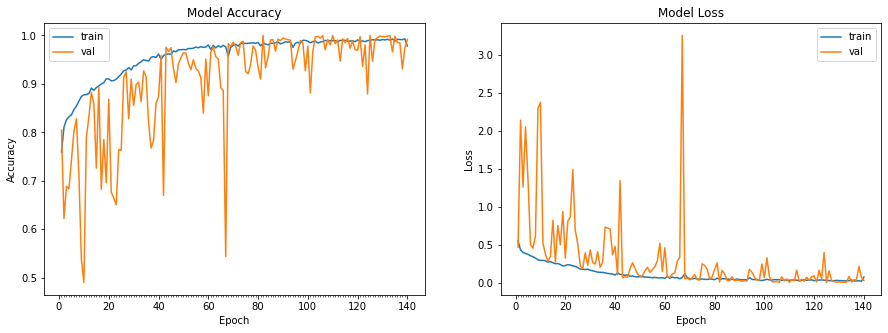

In [36]:
plot_model_history(acc_1,vacc_1,loss_1,vloss_1)

# Confusion Matrix

In [37]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=12,weight='bold')
    #plt.legend('off')
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0,fontsize=12,weight='bold')
        plt.yticks(tick_marks, target_names,fontsize=12,weight='bold')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=12,weight='bold')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=12,weight='bold')
    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,weight='bold')
    plt.xlabel('\n Predicted label \n Test accuracy={:0.2f}%; Misclass={:0.2f}%'.format(accuracy*100, misclass*100),fontsize=12,weight='bold')
    #plt.get_legend().remove()
    
    plt.show()

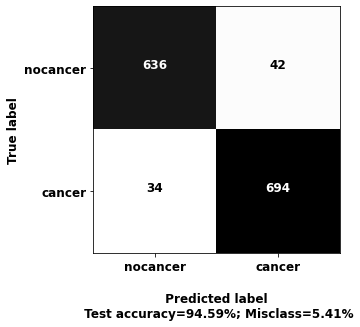

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
plot_confusion_matrix(cm = cm,normalize= False,cmap ='binary',target_names = ['nocancer', 'cancer'],
                      title= '')

In [39]:
tn, fp, fn, tp = confusion_matrix(Y_test,y_pred).ravel()
print(tn, fp, fn, tp)

636 42 34 694


In [40]:
print("Sensitivity %.2f%%" % ((tp / (tp + fn))*100))

Sensitivity 95.33%


In [41]:
print("Specificity %.2f%%" % ((tn / (tn + fp))*100))

Specificity 93.81%


# Classification Report

In [42]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_test, y_pred, target_names=['nocancer','cancer'])

print(report)

              precision    recall  f1-score   support

    nocancer       0.95      0.94      0.94       678
      cancer       0.94      0.95      0.95       728

    accuracy                           0.95      1406
   macro avg       0.95      0.95      0.95      1406
weighted avg       0.95      0.95      0.95      1406



In [43]:
print("%.2f%%" % (metrics.f1_score(Y_test, y_pred,average='weighted')*100))

94.59%


# Saving Train / Validation Data

In [ ]:
RAW_result = pd.DataFrame()

In [ ]:
RAW_result['raw_acc'] = acc_1
RAW_result['raw_vacc'] = vacc_1
RAW_result['raw_loss'] = loss_1
RAW_result['raw_vloss'] = vloss_1

In [ ]:
RAW_result.head()

In [ ]:
RAW_result.to_csv('raw_results.csv', sep='\t', encoding='utf-8')